# n-Local Chain Network Optimization

This notebook uses gradient descent to reproduce the nonlocality results for the $n$-local chain network as described in ["Correlations in n-local scenario"](https://arxiv.org/abs/1411.4188).

![](images/n-local_chain_network.png)

## Binary Inputs and Outputs

Consider classical inputs $x_i$ and $a_i \in \{0,1\}$ for all $i\in\{0,1,\dots,n+1\}$.
The $n$-local chain network correlation are then expressed

$$
P(a_1,\dots,a_{n+1}|x_1,\dots,x_{n+1}) = \text{Tr}\left[\Big(\bigotimes_{i=1}^{n+1}\Pi_{a_i}^{x_i}\Big)\Big(\bigotimes_{j=1}^n \Phi_j \Big)\right],
$$

where each $\Phi_j$ is a bipartite state shared between two measurement nodes and each $\Pi_{a_i}^{x_i}$ is a two-outcome, projective measurement.
Note that the measurements on the two end-nodes ($i=1$, $i=n+1$) are single qubit measurements while the interior nodes perform two-qubit measurements.
The n-local correlators are expressed as

$$
\langle A_1^{x_1},\dots,A_{n+1}^{x_{n+1}} \rangle = \sum_{a_1,\dots,a_{n+1}} (-1)^{\sum_{i=1}^{n+1}a_i}P(a_1,\dots,a_{n+1}|x_1,\dots,x_{n+1}).
$$

The $n$-local Bell inequality is expressed as

$$
\sqrt{|I|}+\sqrt{|J|} \leq 1,
$$

where

$$
I = \frac{1}{4} \sum_{x_1,x_{n+1}\in\{0,1\}}\langle A_1^{x_1},A_2^0,\dots,A_n^0,A_{n+1}^{x_{n+1}} \rangle,
$$

$$
J = \frac{1}{4} \sum_{x_1,x_{n+1}\in\{0,1\}}(-1)^{x_1 + x_{n+1}}\langle A_1^{x_1},A_2^1,\dots,A_n^1,A_{n+1}^{x_{n+1}} \rangle.
$$


## Setup

In [1]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
import time

## General $n$-Local `QNode` Construction

An $n$-local chain network contains $n$ Bell pairs and therefore requires $2n$ qubits.
The $n$-local correlator $\langle A_1^{x_1},\dots,A_{n+1}^{x_{n+1}} \rangle$ is computed by performing local qubit measurements in the $x$-$z$-plane.
Each measurement is prepared with a single qubit `RY` gate followed by a measurement in the computational basis.
Below we generalize the `QNode` construction for an arbitrary $n$-local chain network.

In [2]:
# function to construct a 2*n qubit device
nlocal_device = lambda n: qml.device("default.qubit", wires=2*n)

# apply measurement in computational basis to each wire
def nlocal_observable(n):
    obs = qml.PauliZ(wires=0)
    for i in range(1, 2*n):
        obs = obs @ qml.PauliZ(wires=i)

    return obs

def nlocal_chain_qnode(n):
    """
    Constructs a QNode that simulates an n-local chain network.
    
    Args:
        n (int) : Number of Bell pairs in the chain network.
    """
    dev = nlocal_device(n)
        
    @qml.qnode(dev)
    def circuit(settings):
        """
        Simulates the n-local chain network.
        Prepares `n` Bell states, performs local `RY` rotations on
        each qubit, and measures in the computational basis.
        
        Args:
            settings (array[float]) : `2*n` real values that specify
                                      the `RY` rotation on each qubit.
        """
        for i in range(n):
            a_id = 2 * i
            b_id = a_id + 1

            # bell state preparation
            qml.Hadamard(wires=a_id)
            qml.CNOT(wires=[a_id,b_id])

            # local rotation for measurement
            qml.RY(settings[a_id], wires=a_id)
            qml.RY(settings[b_id], wires=b_id)
        
        return qml.expval(nlocal_observable(n))

    return circuit

In [3]:
# Random settings for n-local chain network
def nlocal_chain_settings(n):
    return 2*np.pi*np.random.random((2*n,2)) - np.pi

## Cost Function: $n$-Local Bell Inequality

In [4]:
# The n-local Bell inequality serves as a cost function
def nlocal_chain_cost(nlocal_settings):
    nlocal_qnode = nlocal_chain_qnode(len(nlocal_settings)//2)
    
    I = _nlocal_I22(nlocal_qnode, nlocal_settings)
    J = _nlocal_J22(nlocal_qnode, nlocal_settings)
    
    return -1*(np.sqrt(abs(I)) + np.sqrt(abs(J)))
  
# helper to calculate I quantity
def _nlocal_I22(nlocal_qnode, nlocal_settings):
    (num_qubits, num_in) = nlocal_settings.shape 
    
    I22 = 0
    for x_start, x_end in [(0,0),(0,1),(1,0),(1,1)]:
        settings = []
        settings.append(nlocal_settings[0,x_start])
        settings.extend(nlocal_settings[1:(num_qubits - 1),0])
        settings.append(nlocal_settings[num_qubits - 1, x_end])
                
        I22 += nlocal_qnode(settings)
        
    return I22/4

# helper to calculate J quantity
def _nlocal_J22(nlocal_qnode, nlocal_settings):
    (num_qubits, num_in) = nlocal_settings.shape 
    
    J22 = 0
    for x_start, x_end in [(0,0),(0,1),(1,0),(1,1)]:
        settings = []
        settings.append(nlocal_settings[0,x_start])
        settings.extend(nlocal_settings[1:(num_qubits - 1),1])
        settings.append(nlocal_settings[num_qubits - 1, x_end])
                
        J22 += ((-1)**(x_start + x_end)) * nlocal_qnode(settings)
        
    return J22/4     

## Gradient Descent Optimization of Nonlocality

In [5]:
# optimization of n-local network nonlocality
def nlocal_gradient_descent(n, num_steps=500):
    opt = qml.GradientDescentOptimizer()    
    nlocal_qnode = nlocal_chain_qnode(n)

    # initial settings
    settings = nlocal_chain_settings(n)
    scores = []

    # performing gradient descent
    for i in range(num_steps):
        settings = opt.step(nlocal_chain_cost, settings)
        
        if i%50 == 0:
            score = -(nlocal_chain_cost(settings))
            scores.append(score)

            print("iteration : ",i, ", score : ", score)
            print("settings :\n", settings, "\n")
    
    final_score = -(nlocal_chain_cost(settings))
    
    return (final_score, settings, scores)

### Example: $(n = 3)$-Local Network

In [6]:
n = 3

n3_qnode = nlocal_chain_qnode(n)
n3_qnode(np.zeros(2*n))

tensor(1., requires_grad=True)

In [7]:
print(n3_qnode.draw())

 0: ──H──╭C──RY(0)──╭┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
 1: ─────╰X──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
 2: ──H──╭C──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
 3: ─────╰X──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
 4: ──H──╭C──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
 5: ─────╰X──RY(0)──╰┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 



In [8]:
%%time

n3_score, n3_settings, n3_scores = nlocal_gradient_descent(n)

# printing final results    
print("final score : ", n3_score,",")
print("final settings : ", n3_settings,"\n")

iteration :  0 , score :  0.5692620006318678
settings :
 [[ 0.23636163  2.74080686]
 [-0.91001554  3.14119981]
 [ 1.9414279  -1.69461494]
 [ 2.74435252  1.83513109]
 [-0.16545621 -0.46723963]
 [-3.0408196   1.91308468]] 

iteration :  50 , score :  0.9631562790999417
settings :
 [[ 0.38096463  2.68027183]
 [-0.98818176  3.13529806]
 [ 2.02540893 -1.65597667]
 [ 2.66037149  1.79649283]
 [-0.21270651 -0.15185707]
 [-3.1474217   1.75155452]] 

iteration :  100 , score :  1.1302200213524682
settings :
 [[ 0.49752015  2.6389261 ]
 [-1.06147353  3.13338003]
 [ 2.09782785 -1.61520927]
 [ 2.58795257  1.75572543]
 [-0.2740628   0.03378496]
 [-3.17318384  1.65303092]] 

iteration :  150 , score :  1.231232185623525
settings :
 [[ 0.58978507  2.60815797]
 [-1.12632922  3.13673894]
 [ 2.15725861 -1.58234778]
 [ 2.52852181  1.72286394]
 [-0.34038551  0.1705529 ]
 [-3.17800259  1.58740445]] 

iteration :  200 , score :  1.2946504970636972
settings :
 [[ 0.66174408  2.58438669]
 [-1.18189464  3.14411

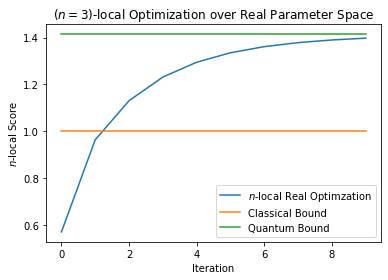

In [9]:
# Plot the score of the Bell inequality
plt.plot(range(10), n3_scores, label = r"$n$-local Real Optimzation")
plt.plot(range(10), [1]*10, label = "Classical Bound")
plt.plot(range(10), [2*np.sqrt(1/2)]*10, label = "Quantum Bound")
plt.title(r"$(n=3)$-local Optimization over Real Parameter Space")
plt.xlabel("Iteration")
plt.ylabel(r"$n$-local Score")
plt.legend()
plt.show()

### Example: $(n=8)$-Local Network

In [10]:
n = 8

n8_qnode = nlocal_chain_qnode(n)
n8_qnode(np.zeros(2*n))

tensor(1., requires_grad=True)

When the settings are initialized to zero, the cost is expected to be $-1$, a saturation of the $n$-local Bell inequality.

In [11]:
nlocal_chain_cost(np.zeros((2*n,2)))

tensor(-1., requires_grad=True)

In [12]:
print(n8_qnode.draw())

  0: ──H──╭C──RY(0)──╭┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  1: ─────╰X──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  2: ──H──╭C──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  3: ─────╰X──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  4: ──H──╭C──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  5: ─────╰X──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  6: ──H──╭C──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  7: ─────╰X──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  8: ──H──╭C──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
  9: ─────╰X──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
 10: ──H──╭C──RY(0)──├┤ ⟨Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z ⊗ Z⟩ 
 11: ─────╰X──RY(0)──

In [13]:
%%time

n8_score, n8_settings, n8_scores = nlocal_gradient_descent(n, num_steps=600)

# printing final results    
print("final score : ", n8_score,",")
print("final settings : ", n8_settings,"\n")

iteration :  0 , score :  0.16572417423795097
settings :
 [[-1.23961666 -0.72531065]
 [-0.98710189  0.63392213]
 [-2.58587332 -1.45952289]
 [ 0.98931404  2.74047499]
 [ 2.14044049 -1.54384283]
 [ 1.45600055 -2.83139924]
 [-1.33508951 -0.19489808]
 [ 1.96334264 -0.04897194]
 [-1.11417736 -0.04552482]
 [-2.5504599   2.71769624]
 [ 1.78547051  1.25801826]
 [ 1.23486063  1.74689301]
 [-0.99555913 -1.75013084]
 [-1.39549312  2.93157107]
 [-2.4069116  -0.61940684]
 [ 2.21032555 -0.38640646]] 

iteration :  50 , score :  0.42350709924347607
settings :
 [[-1.26468226 -0.69968315]
 [-0.98683414  0.63309248]
 [-2.56086954 -1.4289889 ]
 [ 0.96431027  2.70994099]
 [ 2.09732232 -1.59666499]
 [ 1.49911871 -2.77857709]
 [-1.3264667  -0.1922422 ]
 [ 1.95471983 -0.05162783]
 [-1.29269192 -0.0526914 ]
 [-2.37194534  2.72486282]
 [ 1.75257881  1.26758743]
 [ 1.26775233  1.73732383]
 [-1.01842925 -1.62864507]
 [-1.37262301  2.8100853 ]
 [-2.39699528 -0.62017012]
 [ 2.12011308 -0.30534703]] 

iteration :  

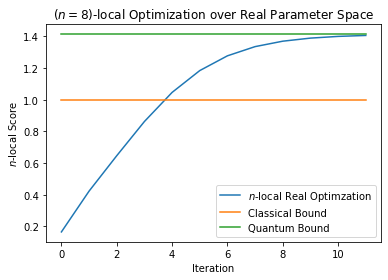

In [14]:
# Plot the score of the Bell inequality
plt.plot(range(12), n8_scores, label = r"$n$-local Real Optimzation")
plt.plot(range(12), [1]*12, label = "Classical Bound")
plt.plot(range(12), [2*np.sqrt(1/2)]*12, label = "Quantum Bound")
plt.title(r"$(n=8)$-local Optimization over Real Parameter Space")
plt.xlabel("Iteration")
plt.ylabel(r"$n$-local Score")
plt.legend()
plt.show()